In [16]:
#from src.feature_selector import load_model
from utils import FEATURE_NAMES
# from analysis.src.plot import plot_action_histogram
import os
import numpy as np
import torch as th

# BASE_PATH = r'C:\initial_model\historic_synthetic_dnnevo\gawrl_old_PPO_23'
# algo='Attention'
# policy = 'MlpPolicy'
# MODEL_PATH  = os.path.join(BASE_PATH, f'{algo.lower()}_{policy}_mlp_gawrl_final')

# BASE_PATH = r'C:\initial_model\historic_synthetic_dnnevo\PPO_40_speedup_600'
# algo='PPO'
# policy = 'MlpPolicy'
# MODEL_PATH  = os.path.join(BASE_PATH, f'{algo.lower()}_{policy}_mlp_vm_waiting')

BASE_PATH = r'C:\initial_model\historic_synthetic_dnnevo\dawrl_old_PPO_50'
    #gawrl_old_PPO_48'
algo='Attention'
policy = 'MlpPolicy'
MODEL_PATH  = os.path.join(BASE_PATH, f'{algo.lower()}_{policy}_mlp_dawrl')


In [17]:
from stable_baselines3 import PPO
model = PPO.load(MODEL_PATH, print_system_info=False)

In [18]:
def print_total_params(module, trainable_only=True):
    """
    Print total number of parameters in a PyTorch module.
    For SB3 models, pass model.policy to count the policy only.
    """
    total = sum(p.numel() for p in module.parameters()
                if (p.requires_grad or not trainable_only))
    print(f"Total parameters: {total:,}")
print_total_params(model.policy)  # policy only

Total parameters: 24,297


In [21]:
from sb3_contrib import RecurrentPPO
model = RecurrentPPO.load(r'C:\initial_model\historic_synthetic_dnnevo\RecurrentPPO_19_worst\recurrentppo_MlpLstmPolicy_mlplstm_policy_worst', print_system_info=False)
#model = RecurrentPPO.load(r'C:\initial_model\historic_synthetic_dnnevo\RecurrentPPO_128_32_Arch\recurrentppo_MlpLstmPolicy_mlplstm_policy_reduced_64_32', print_system_info=False)

In [19]:
from driver.common.cmd_util import (
    common_arg_parser,
    parse_unknown_args
)
import sys
from run import configure_logger, parse_cmdline_kwargs
# pretend these were typed on the command line
argv = """
  --env ThreeSizeAppEnv-v1 --policy CnnLstmPolicy --algo RecurrentAttention --num_timesteps 2_000 --pretraining_timesteps 2_000 --tensorboard_log '.' --workload_file TEST-DNNEVO-2.swf
""".split()
arg_parser = common_arg_parser()
args, unknown_args = arg_parser.parse_known_args(argv)
configure_logger(args.log_path, format_strs=['stdout', 'log', 'csv'])
extra_args = parse_cmdline_kwargs(unknown_args)
#extra_args['use_random_wrapper']=True
from run import build_env
#args.observation_history_length = 8
args.queue_wait_penalty=0.036
args.initial_vm_count=1
args.mips_per_core=10000
env = build_env(args, extra_args)

format_strs: ['stdout', 'log', 'csv']
2025-09-26 21:21:17,490443: Logging to C:\Users\ULTRAM~1\AppData\Local\Temp\openai-2025-09-26-21-21-17-473443\2025-09-26.1 in formats [<HumanOutputFormat(stdout)>, <HumanOutputFormat(C:\Users\ULTRAM~1\AppData\Local\Temp\openai-2025-09-26-21-21-17-473443\2025-09-26.1\log.txt)>, <driver.logger.CSVOutputFormat object at 0x000002BC7B4213C8>]
2025-09-26 21:21:17,494443: Loading workload from file: TEST-DNNEVO-2.swf
2025-09-26 21:21:17,502444: Dumping jobs available for training
2025-09-26 21:21:17,505448: {'jobId': 1, 'submissionDelay': 3600, 'mi': 9000000, 'numberOfCores': 1}
2025-09-26 21:21:17,508448: {'jobId': 2, 'submissionDelay': 3600, 'mi': 9000000, 'numberOfCores': 1}
2025-09-26 21:21:17,509448: {'jobId': 3, 'submissionDelay': 3600, 'mi': 9000000, 'numberOfCores': 1}
2025-09-26 21:21:17,511446: {'jobId': 4, 'submissionDelay': 3600, 'mi': 9000000, 'numberOfCores': 1}
2025-09-26 21:21:17,512444: {'jobId': 5, 'submissionDelay': 3600, 'mi': 9000000,

c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [27]:
import time
import numpy as np

# ---------- Correlation helpers ----------

def compute_corr_matrix(obs_batch, method: str = "pearson", eps: float = 1e-12) -> np.ndarray:
    """
    obs_batch: array-like (T, ..., F) where the LAST dimension are features.
    Returns (F, F) correlation matrix.
    """
    X = np.asarray(obs_batch, dtype=np.float64)
    if X.ndim < 2:
        raise ValueError(f"Need at least (N,F) array; got {X.shape}")
    F = X.shape[-1]
    X = X.reshape(-1, F)

    # drop rows with NaNs
    if np.isnan(X).any():
        X = X[~np.isnan(X).any(axis=1)]
    if X.shape[0] < 2:
        raise ValueError("Not enough valid samples after NaN filtering.")

    m = method.lower()
    if m == "pearson":
        X = (X - X.mean(axis=0)) / (X.std(axis=0) + eps)
        C = (X.T @ X) / max(1, X.shape[0] - 1)
    elif m == "spearman":
        try:
            from scipy.stats import rankdata  # type: ignore
            R = np.column_stack([rankdata(X[:, i], method="average") for i in range(F)])
        except Exception:
            # simple fallback ranker if scipy/pandas unavailable
            R = np.empty_like(X)
            order = np.argsort(X, axis=0, kind="mergesort")
            for i in range(F):
                ranks = np.empty(X.shape[0], dtype=float)
                ranks[order[:, i]] = np.arange(X.shape[0], dtype=float)
                R[:, i] = ranks
        R = (R - R.mean(axis=0)) / (R.std(axis=0) + eps)
        C = (R.T @ R) / max(1, R.shape[0] - 1)
    else:
        raise ValueError("method must be 'pearson' or 'spearman'")

    return np.clip(C, -1.0, 1.0)

def print_top_corr(C: np.ndarray, k: int = 10, names=None):
    F = C.shape[0]
    names = names or [f"f{i}" for i in range(F)]
    tri = np.triu_indices(F, k=1)
    pairs = list(zip(tri[0], tri[1], np.abs(C[tri]).tolist()))
    pairs.sort(key=lambda t: t[2], reverse=True)
    print(f"Top {min(k, len(pairs))} |corr| pairs:")
    for i, j, a in pairs[:k]:
        print(f"  {names[i]} ↔ {names[j]} : ρ={C[i, j]:+.3f}")

# ---------- Rollout & collection ----------
import numpy as np

def rollout_collect_obs(env, n_steps: int = 5000, use_raw_from_info: bool = False, info_key: str = "_raw_obs"):
    """
    Step the env with random actions and collect observations for correlation.
    Returns X of shape (N, F), where F is the last dimension of the observation.

    - Supports Gym single env and SB3 VecEnv.
    - If use_raw_from_info=True, tries to read pre-mask obs from info[info_key].
    """
    # Detect SB3 VecEnv
    try:
        from stable_baselines3.common.vec_env.base_vec_env import VecEnv  # type: ignore
        is_vec = isinstance(env, VecEnv)
        n_envs = env.num_envs if is_vec else 1
    except Exception:
        is_vec, n_envs = False, 1

    # Reset (handle Gymnasium-style (obs, info) too, just in case)
    reset_out = env.reset()
    obs = reset_out[0] if (isinstance(reset_out, tuple) and len(reset_out) == 2) else reset_out

    def obs_to_rows(x):
        arr = np.asarray(x)
        F = arr.shape[-1]
        return arr.reshape(-1, F)  # flatten all leading axes

    rows = []
    # include initial observation(s)
    if not use_raw_from_info:
        rows.append(obs_to_rows(obs))

    for _ in range(n_steps):
        # ----- random action -----
        if is_vec:
            # sample one action per sub-env
            acts = [env.action_space.sample() for _ in range(n_envs)]
            # stack into a suitable array
            try:
                #action = np.asarray(acts)
                action = np.asarray([int(env.action_space.sample()) for _ in range(env.num_envs)], dtype=np.int64)
            except Exception:
                action = np.array(acts, dtype=object)
        else:
            action = env.action_space.sample()

        step_out = env.step(action)

        if is_vec:
            next_obs, rewards, dones, infos = step_out
            if use_raw_from_info:
                # prefer _raw_obs from info if present, else fall back to next_obs[i]
                per_env_obs = []
                for i in range(n_envs):
                    raw_i = infos[i].get(info_key) if isinstance(infos[i], dict) else None
                    per_env_obs.append(raw_i if raw_i is not None else next_obs[i])
                rows.append(obs_to_rows(np.stack(per_env_obs, axis=0)))
            else:
                rows.append(obs_to_rows(next_obs))
            obs = next_obs  # VecEnv autohandles resets internally
        else:
            # Single env: support Gym (4-tuple) and Gymnasium (5-tuple)
            if isinstance(step_out, tuple) and len(step_out) == 5:
                next_obs, reward, terminated, truncated, info = step_out
                done = bool(terminated) or bool(truncated)
            else:
                next_obs, reward, done, info = step_out

            if use_raw_from_info and isinstance(info, dict) and info_key in info:
                rows.append(obs_to_rows(info[info_key]))
            else:
                rows.append(obs_to_rows(next_obs))

            if done:
                reset_out = env.reset()
                next_obs = reset_out[0] if (isinstance(reset_out, tuple) and len(reset_out) == 2) else reset_out
            obs = next_obs

    X = np.concatenate(rows, axis=0)  # (N, F)
    return X


# ---------- One-shot convenience wrapper ----------

def correlate_env_metrics(env, model=None, steps=5000, method="pearson",
                          names=None, use_raw_from_info=False, info_key="_raw_obs"):
    """
    Runs rollout, computes correlation matrix, prints a quick report, returns C.
    """
    X = rollout_collect_obs(env, n_steps=steps)
    C = compute_corr_matrix(X, method=method)
    print_top_corr(C, k=min(10, C.shape[0]*(C.shape[0]-1)//2), names=names)
    return C


In [28]:
# 1) Correlate the *observations seen by the agent*
C = correlate_env_metrics(env, model=None, steps=10_000, method="pearson",
                          names=["vmAlloc","avgCPU","avgMem","p90Mem","p90CPU","waitGlob","waitRecent"])

# # 2) If you use FeatureMaskWrapper(expose_raw=True) and want *pre-mask* metrics:
# C_raw = correlate_env_metrics(env, model=None, steps=10_000, method="spearman",
#                               names=[...], use_raw_from_info=True, info_key="_raw_obs")

# 3) With a trained SB3 model driving the env:
# from stable_baselines3 import PPO
# model = PPO.load("path/to/model.zip")
# C_model = correlate_env_metrics(env, model=model, steps=20_000, method="pearson")


Top 10 |corr| pairs:
  p90Mem ↔ p90CPU : ρ=+0.695
  avgCPU ↔ avgMem : ρ=+0.568
  avgMem ↔ p90Mem : ρ=+0.458
  vmAlloc ↔ waitGlob : ρ=-0.383
  avgCPU ↔ waitGlob : ρ=+0.352
  avgCPU ↔ p90Mem : ρ=+0.346
  vmAlloc ↔ p90Mem : ρ=-0.323
  avgMem ↔ waitGlob : ρ=+0.319
  vmAlloc ↔ avgMem : ρ=-0.288
  waitGlob ↔ waitRecent : ρ=+0.265


In [19]:
X = np.load(os.path.join(BASE_PATH, f'observations_attention_MlpPolicy_1.npy'))
#X = th.Tensor(X)
X.shape

(2410, 1, 7)

In [16]:
import numpy as np

def compute_corr_matrix(obs_batch, method: str = "pearson", eps: float = 1e-12) -> np.ndarray:
    """
    obs_batch: array-like of shape (N, ..., F). Last dim = features.
    method: "pearson" | "spearman"
    returns: (F, F) correlation matrix
    """
    X = np.asarray(obs_batch, dtype=np.float64)
    if X.ndim < 2:
        raise ValueError(f"Expected at least 2D (samples, features), got shape {X.shape}")
    F = X.shape[-1]
    X = X.reshape(-1, F)

    # Drop rows with NaNs
    if np.isnan(X).any():
        X = X[~np.isnan(X).any(axis=1)]
    if X.shape[0] < 2:
        raise ValueError("Not enough valid samples to compute correlation.")

    if method.lower() == "pearson":
        # standardize columns
        X = (X - X.mean(axis=0)) / (X.std(axis=0) + eps)
        C = (X.T @ X) / max(1, X.shape[0] - 1)
        return np.clip(C, -1.0, 1.0)

    elif method.lower() == "spearman":
        # rank-transform each column; use SciPy/Pandas if available, else a simple fallback
        try:
            from scipy.stats import rankdata  # type: ignore
            R = np.column_stack([rankdata(X[:, i], method="average") for i in range(F)])
        except Exception:
            try:
                import pandas as pd  # type: ignore
                R = np.column_stack([pd.Series(X[:, i]).rank(method="average").to_numpy() for i in range(F)])
            except Exception:
                # Fallback: simple ranks without tie averaging
                R = np.empty_like(X)
                order = np.argsort(X, axis=0, kind="mergesort")
                for i in range(F):
                    ranks = np.empty(X.shape[0], dtype=float)
                    ranks[order[:, i]] = np.arange(X.shape[0], dtype=float)
                    R[:, i] = ranks

        R = (R - R.mean(axis=0)) / (R.std(axis=0) + eps)
        C = (R.T @ R) / max(1, R.shape[0] - 1)
        return np.clip(C, -1.0, 1.0)
    else:
        raise ValueError("method must be 'pearson' or 'spearman'")

def print_corr(C: np.ndarray, names=None):
    """Pretty-print the correlation matrix with optional metric names."""
    F = C.shape[0]
    names = names or [f"f{i}" for i in range(F)]
    w = max(max(len(n) for n in names), 5) + 1
    print("".ljust(w) + " ".join(f"{n:>{w}}" for n in names))
    for i, n in enumerate(names):
        row = " ".join(f"{C[i, j]:>{w}.2f}" for j in range(F))
        print(f"{n:>{w}} {row}")


In [20]:
predictions = []
for _ in X:
    #predictions.append(model.predict(X[0])[0][0])
    #predictions.append(model.predict(_)[0][0])
    predictions.append(model.predict(_)[0])
    

predictions = np.array(predictions)

In [55]:
predictions[1456]

5

In [8]:
# If you're in Jupyter/Colab, run this line first in a separate cell:
# %matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# predictions = np.array([...])  # your (2410,) array

predictions = np.asarray(predictions)

# Drop NaNs if floats
if predictions.dtype.kind in "f":
    predictions = predictions[~np.isnan(predictions)]

unique_vals, counts = np.unique(predictions, return_counts=True)
unique_count = len(unique_vals)

# Heuristic: if many unique values, use a histogram; else show counts per value
UNIQUE_THRESHOLD = 50

if unique_count <= UNIQUE_THRESHOLD:
    # Sort labels nicely (numeric if numeric, else lexicographic)
    if unique_vals.dtype.kind in "iuf":  # int/uint/float
        order = np.argsort(unique_vals.astype(float))
    else:
        order = np.argsort(unique_vals.astype(str))
    unique_vals = unique_vals[order]
    counts = counts[order]

    x = np.arange(unique_count)
    plt.figure(figsize=(12, 4))
    plt.bar(x, counts)
    plt.xticks(x, unique_vals, rotation=45, ha="right")
    plt.xlabel("Akcja")
    plt.ylabel("Liczba wybranych akcji")
    plt.title("Wybierane akcje")
    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize=(12, 4))
    plt.hist(predictions.astype(float), bins="auto")
    plt.xlabel("Prediction value")
    plt.ylabel("Count")
    plt.title("Histogram of prediction values")
    plt.tight_layout()
    plt.show()


c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [21]:
obs = X.squeeze(1)
# obs = obs[450]

In [22]:
mask = (obs[:, 1:] != 0).any(axis=1)
# select rows that match
filtered = obs[mask]
len(filtered)

625

In [23]:
# get the indices
indices = np.where(mask)[0]
indices

array([  59,   60,   61,   62,   63,   64,   65,   66,   67,   68,   69,
         70,   71,   72,   73,   74,   75,   76,   77,   78,   79,   80,
         81,   82,   83,   84,   85,   86,   87,   88,   89,   90,   91,
         92,   93,   94,   95,   96,   97,   98,   99,  100,  101,  102,
        103,  104,  105,  106,  107,  108,  109,  110,  111,  112,  113,
        114,  115,  116,  117,  118,  119,  120,  239,  300,  301,  302,
        303,  304,  305,  306,  307,  308,  309,  310,  311,  312,  313,
        314,  315,  316,  317,  318,  319,  320,  321,  322,  323,  324,
        325,  326,  327,  328,  329,  330,  331,  332,  333,  334,  335,
        336,  337,  338,  339,  340,  341,  342,  343,  344,  345,  346,
        347,  348,  349,  350,  351,  352,  353,  354,  355,  356,  357,
        358,  359,  360,  361,  480,  541,  542,  543,  544,  545,  546,
        547,  548,  549,  550,  551,  552,  553,  554,  555,  556,  557,
        558,  559,  560,  561,  562,  563,  564,  5

In [27]:
obs

array([[ 0.07857143,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.        ],
       [ 0.07857143,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.        ],
       [ 0.10714286,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.        ],
       ...,
       [ 0.95714283,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.95714283,  0.        ,  0.        , ...,  0.        ,
         0.0070922 ,  0.0125    ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [24]:
from attention_gawrl_viz import *
# Attention (either PPO or RecurrentPPO model)
#obs = obs[59]
fig = plot_attention_state_from_model(model, obs, feature_names=FEATURE_NAMES)

# IG for one state (works for both)
# attrs, y = compute_ig_single(model, obs, mode="value", baseline="zeros", n_steps=64)
# fig_ig = plot_ig_single_bar(attrs, feature_names=FEATURE_NAMES, absolute=True)


c:\Users\ultramarine\Desktop\ppo_magisterka\trainloop_driver_official\trainloop_driver_final\trainloop-driver\attention_gawrl_viz.py:521: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


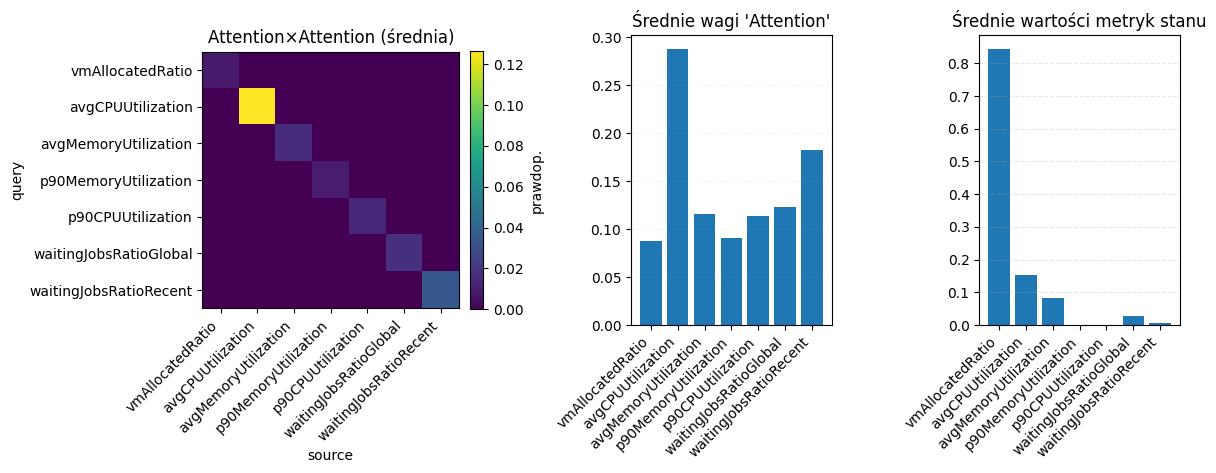

In [25]:
display(fig)

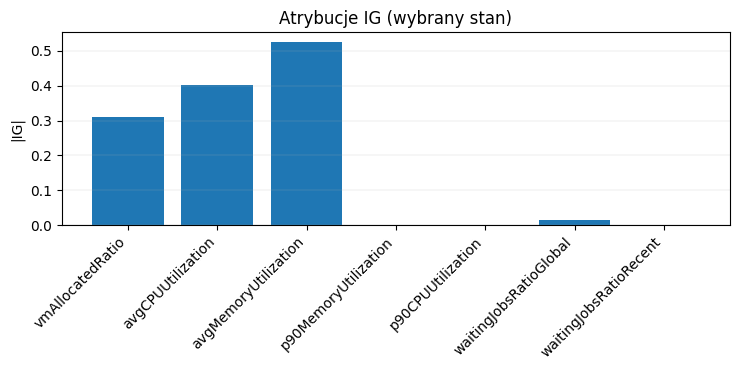

In [39]:
display(fig_ig)

In [9]:
out = predict_with_attention(model, obs, deterministic=True)
print("Action:", out["action"])
print("Per-feature attention (len=7):", out["per_feature"])
print("Attention matrix shape:", out["attention_matrix"].shape)

Action: 5
Per-feature attention (len=7): [[2.6300445e-02 4.3599810e-03 2.1427451e-02 2.1427451e-02 2.1427451e-02
  2.6486924e-02 2.1427451e-02]
 [4.5002992e-03 1.2648199e-01 1.3758305e-03 1.3758305e-03 1.3758305e-03
  6.3715279e-03 1.3758305e-03]
 [2.0469844e-02 2.0790230e-02 1.9756369e-02 1.9756369e-02 1.9756369e-02
  2.2571610e-02 1.9756369e-02]
 [2.0469844e-02 2.0790230e-02 1.9756369e-02 1.9756369e-02 1.9756369e-02
  2.2571610e-02 1.9756369e-02]
 [2.0469844e-02 2.0790230e-02 1.9756369e-02 1.9756369e-02 1.9756369e-02
  2.2571610e-02 1.9756369e-02]
 [2.8206060e-02 3.8348677e-05 4.3902448e-03 4.3902448e-03 4.3902448e-03
  9.7051769e-02 4.3902448e-03]
 [2.0469844e-02 2.0790230e-02 1.9756369e-02 1.9756369e-02 1.9756369e-02
  2.2571610e-02 1.9756369e-02]]
Attention matrix shape: (1, 7, 7)


In [8]:
idx=9
obs = X[idx][0]
A, per_feat = get_attention_for_obs(model, obs)
print("A shape:", A.shape)                 # (7, 7)
print("Per-feature attention:", per_feat)  # length 7


A shape: (7, 7)
Per-feature attention: [0.14088617 0.21404123 0.10621899 0.10621899 0.10621899 0.22019662
 0.10621899]


In [8]:
fig, per_feat, state = plot_attention_and_state(
    model, obs,
    feature_names=FEATURE_NAMES,
    normalize_state=True
)
display(fig)


NameError: name 'plot_attention_and_state' is not defined

In [11]:
#PPO
from typing import Optional, Union
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from captum.attr import IntegratedGradients
from matplotlib.figure import Figure
from IPython.display import display

class PolicyScalarWrapper(nn.Module):
    """
    Wrap an SB3 policy into a scalar-output nn.Module for Captum.
    mode='value' -> V(s); mode='action' -> chosen action logit (Discrete).
    """
    def __init__(self, policy, mode: str = "value", action_index: Optional[int] = None):
        super().__init__()
        self.policy = policy
        self.mode = mode.lower()
        self.action_index = action_index

    def forward(self, x: th.Tensor) -> th.Tensor:
        # x: [B, D], goes through your AttentiveAWRLFeatureExtractor
        feats = self.policy.extract_features(x)
        latent_pi, latent_vf = self.policy.mlp_extractor(feats)

        if self.mode == "value":
            return self.policy.value_net(latent_vf).squeeze(-1)  # [B]

        # Action logit (Discrete); if action_index None, use argmax per sample
        try:
            logits = self.policy.action_net(latent_pi)           # [B, A]
            if self.action_index is None:
                idx = logits.argmax(dim=-1)                      # [B]
            else:
                idx = th.full((logits.size(0),), int(self.action_index),
                              device=logits.device, dtype=th.long)
            return logits.gather(1, idx.view(-1, 1)).squeeze(1)
        except Exception:
            # Fallback to value if not discrete
            return self.policy.value_net(latent_vf).squeeze(-1)

def compute_ig_single(
    model,
    obs: Union[np.ndarray, th.Tensor],        # shape (7,)
    mode: str = "value",                      # "value" or "action"
    action_index: Optional[int] = None,       # only for mode="action"
    baseline: Union[str, np.ndarray, th.Tensor] = "zeros",  # "zeros" or a 7-d baseline vector
    n_steps: int = 64
):
    """
    Returns:
      attrs: np.ndarray [7]  (signed IG attribution for this obs)
      scalar_out: float       (value or action logit used as target)
    """
    device = model.device
    # SB3-friendly preprocessing (handles dtype, device)
    x_t, _ = model.policy.obs_to_tensor(obs)      # [1,7]
    x_t = x_t.to(device).float().requires_grad_(True)

    # Baseline
    if isinstance(baseline, str):
        if baseline == "zeros":
            base_t = th.zeros_like(x_t)
        else:
            raise ValueError("baseline must be 'zeros' or a 7-d vector")
    else:
        base_arr = baseline if isinstance(baseline, np.ndarray) else baseline.detach().cpu().numpy()
        base_t = th.as_tensor(base_arr, dtype=th.float32, device=device).view(1, -1)

    wrapper = PolicyScalarWrapper(model.policy, mode=mode, action_index=action_index).to(device)
    ig = IntegratedGradients(wrapper)

    attrs_t = ig.attribute(inputs=x_t, baselines=base_t, n_steps=int(n_steps))  # [1,7]
    attrs = attrs_t[0].detach().cpu().numpy()

    # Also compute the scalar output for reference
    with th.no_grad():
        scalar_out = float(wrapper(x_t).item())

    return attrs, scalar_out

def plot_ig_single_bar(
    attrs: np.ndarray,
    feature_names: Optional[list] = None,
    title: str = "IG attributions (single state)",
    rotation: int = 45, ha: str = "right",
    absolute: bool = False
):
    """
    Barplot of IG attributions for one observation.
    Set absolute=True to plot |attribution| instead of signed.
    """
    vals = np.abs(attrs) if absolute else attrs
    idx = np.arange(len(vals))
    labels = feature_names if feature_names is not None else [f"M{i}" for i in idx]

    fig = Figure(figsize=(7.5, 3.8))
    ax = fig.add_subplot(111)

    # Color positive vs negative (signed) for readability
    colors = None if absolute else ["tab:blue" if v >= 0 else "tab:red" for v in vals]

    ax.bar(idx, vals.astype(float), linewidth=0.5, color=colors)
    ax.axhline(0.0, color="black", linewidth=0.6)
    ax.set_title(title)
    ax.set_ylabel("|IG|" if absolute else "IG (signed)")
    ax.set_xticks(idx)
    ax.set_xticklabels(labels, rotation=rotation, ha=ha)
    ax.grid(True, axis="y", linewidth=0.3, alpha=0.5)
    fig.tight_layout()
    return fig

# ----- Attention visualization helpers (Py3.7-safe) -----
import numpy as np
import torch as th
import torch.nn.functional as F
import matplotlib.pyplot as plt


def get_attention_for_state(extractor, obs, normalize=True):
    """
    Run a single state through the feature extractor and return:
      A   : [7,7] attention (row-softmaxed if normalize=True)
      imp : [7]   per-metric attention summary (extractor.metric_importance[0])
      alpha: float or None (only for qk_mode='hybrid')
    """
    device = next(extractor.parameters()).device
    x = th.as_tensor(obs, dtype=th.float32, device=device).view(1, -1)
    with th.no_grad():
        _ = extractor(x)                 # populates attn_matrix & metric_importance
        A = extractor.attn_matrix[0]     # [7,7]
        if normalize and extractor.attn_norm != "row_softmax":
            A = F.softmax(A, dim=-1)
        imp = extractor.metric_importance[0]  # [7]
        alpha = None
        if getattr(extractor, "qk_mode", "content") == "hybrid" and getattr(extractor, "alpha_param", None) is not None:
            alpha = float(th.sigmoid(extractor.alpha_param).item())
    return A, imp, alpha


def plot_attention_state(
    extractor,
    obs,
    feature_names=None,    # list of 7 names
    normalize=True,
    rotate=45,
):
    """
    Notebook plot with 3 panels:
      - 7x7 attention heatmap (rows=query i, cols=source j)
      - per-metric attention weights (column-importance)
      - raw state values
    """
    A, imp, alpha = get_attention_for_state(extractor, obs, normalize=normalize)

    names = feature_names if (feature_names is not None and len(feature_names) == extractor.n_metrics) \
            else [f"f{i}" for i in range(extractor.n_metrics)]
    vals = th.as_tensor(obs, dtype=th.float32).view(-1)[: extractor.n_metrics].cpu().numpy()
    imp_np = imp.detach().cpu().numpy()
    A_np = A.detach().cpu().numpy()

    # Title suffix (show α only for hybrid)
    alpha_txt = f" — α={alpha:.2f}" if alpha is not None else ""

    fig = plt.figure(figsize=(12, 4.8))
    gs = fig.add_gridspec(1, 3, width_ratios=[1.4, 1.0, 1.0])

    # Heatmap
    ax0 = fig.add_subplot(gs[0, 0])
    im = ax0.imshow(A_np, aspect="auto")
    ax0.set_title(f"Attention (rows→cols){alpha_txt}")
    ax0.set_xlabel("source metrics (j)")
    ax0.set_ylabel("query metrics (i)")
    ax0.set_xticks(range(len(names)))
    ax0.set_yticks(range(len(names)))
    ax0.set_xticklabels(names, rotation=rotate, ha="right")
    ax0.set_yticklabels(names)
    cbar = plt.colorbar(im, ax=ax0, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("prob." if normalize or extractor.attn_norm == "row_softmax" else "score", rotation=90)

    # Per-metric attention weights
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.bar(range(len(imp_np)), imp_np)
    ax1.set_title("Per-metric attention")
    ax1.set_xticks(range(len(names)))
    ax1.set_xticklabels(names, rotation=rotate, ha="right")
    ax1.grid(True, axis="y", linestyle="--", alpha=0.3)

    # Raw state values
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.bar(range(len(vals)), vals)
    ax2.set_title("State values")
    ax2.set_xticks(range(len(names)))
    ax2.set_xticklabels(names, rotation=rotate, ha="right")
    ax2.grid(True, axis="y", linestyle="--", alpha=0.3)

    fig.tight_layout()
    plt.show()
    return fig




In [10]:
# pick a fixed action index at the actual state
with th.no_grad():
    x_t, _ = model.policy.obs_to_tensor(obs)
    feats = model.policy.extract_features(x_t)
    latent_pi, _ = model.policy.mlp_extractor(feats)
    logits = model.policy.action_net(latent_pi)           # [1, A]
    act_idx = int(logits.argmax(dim=-1).item())           # fix the target

# IG w.r.t. that fixed action logit
ig_act, logit_val = compute_ig_single(
    model, obs,
    mode="action",
    action_index=act_idx,     # <-- keep target fixed along the path
    baseline="zeros",
    n_steps=64
)
fig_act = plot_ig_single_bar(
    ig_act, FEATURE_NAMES,
    title=f"IG → Action logit[{act_idx}] = {float(logit_val):.3f}",
    absolute=True
)


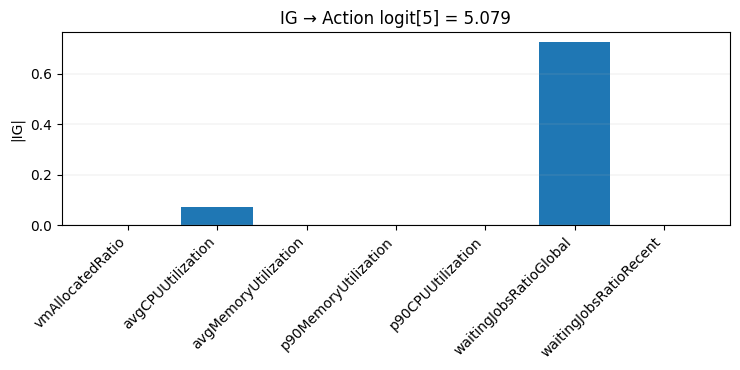

In [11]:
display(fig_act)

c:\Users\ultramarine\Desktop\ppo_magisterka\trainloop_driver_official\trainloop-driver\viz_utils.py:234: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.tight_layout()


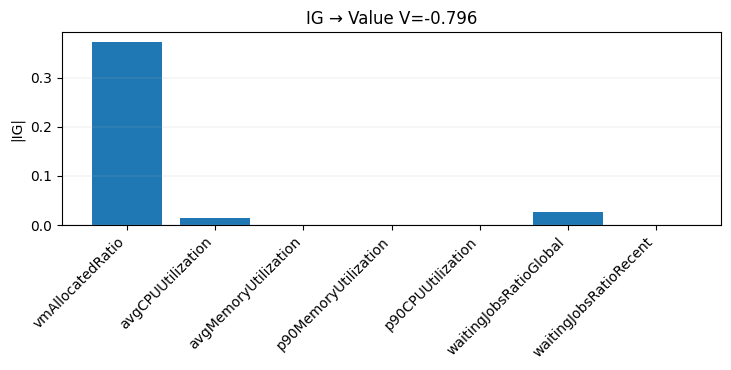

In [12]:
# IG TO THE VALUE
ig_val, V = compute_ig_single(model, obs, mode="value", baseline="zeros", n_steps=64)
fig_val = plot_ig_single_bar(
    ig_val, FEATURE_NAMES,
    title=f"IG → Value V={V:.3f}",
    absolute=True
)
display(fig_val)

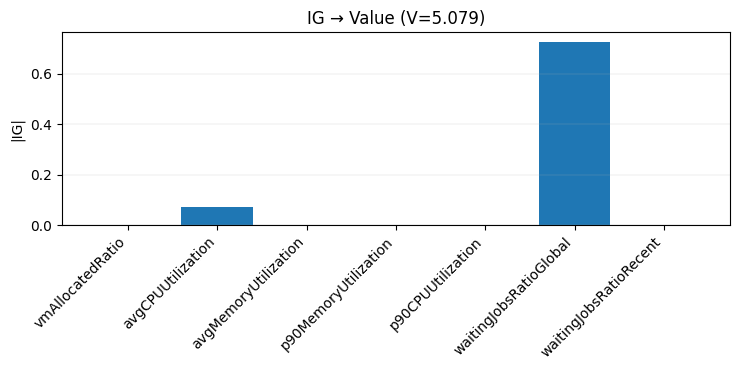

In [9]:

ig_vec, target_val = compute_ig_single(model, obs, mode="action", baseline="zeros", n_steps=64)
fig = plot_ig_single_bar(
    ig_vec,
    feature_names=FEATURE_NAMES,
    title=f"IG → Value (V={target_val:.3f})",
    rotation=45, ha="right", absolute=True
)
display(fig)


c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\ipykernel_launcher.py:199: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


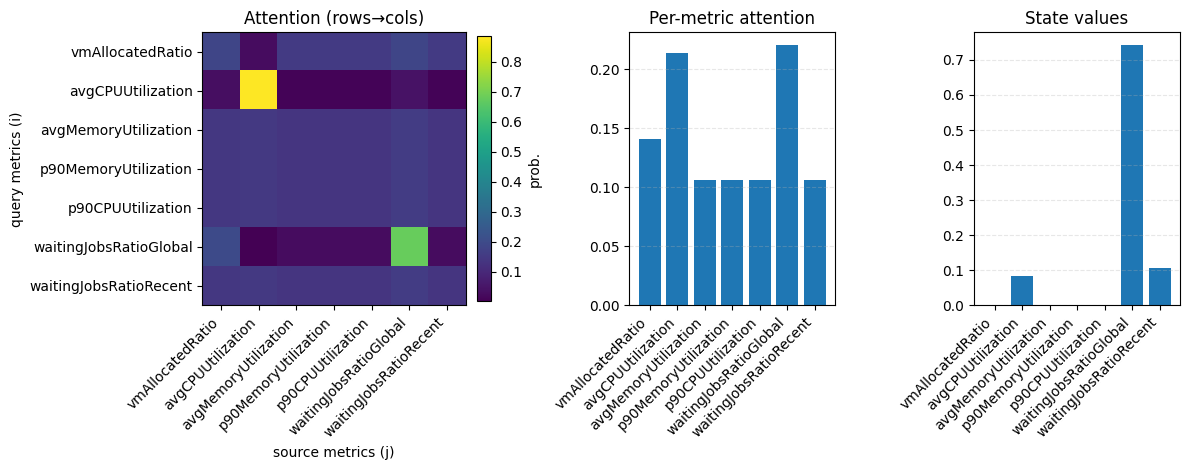

In [23]:
plot_attention_state(model.policy.features_extractor, obs, feature_names=FEATURE_NAMES)

c:\Users\ultramarine\Desktop\ppo_magisterka\trainloop_driver_official\trainloop-driver\viz_utils.py:255: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.tight_layout()


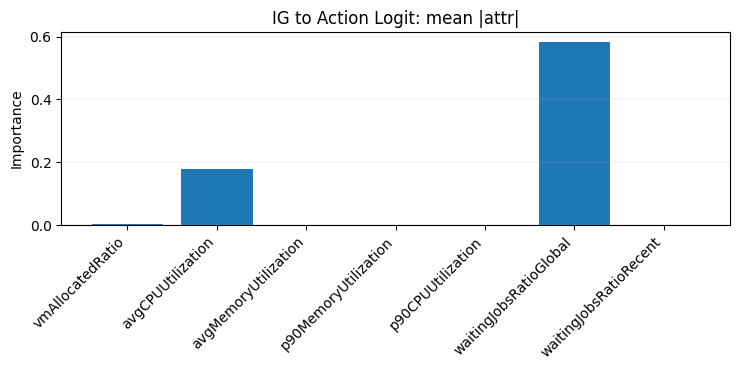

In [11]:
# X: shape [N, D] batch of observations
mean_abs_a, mean_signed_a, attrs_a = compute_ig_attributions(
    model,
    obs_batch=X.squeeze(1),
    mode="action",          # use action logit as target
    action_index=None,      # None => per-sample argmax; or give an int
    n_steps=64,
    baseline="zeros",
    chunk_size=1            # safest; raise to 8/16 if your FE is robust
)

fig2 = plot_ig_bar(
    mean_abs_a,
    feature_names=FEATURE_NAMES,
    title="IG to Action Logit: mean |attr|"
)

# In notebooks, show it:
from IPython.display import display
display(fig2)


In [12]:
import numpy as np
import torch as th
import torch.nn.functional as F
from matplotlib.figure import Figure
from IPython.display import display

def get_attention_for_obs(model, obs):
    """
    Returns:
      A: [7,7] attention matrix for this state (averaged over batch if needed)
      per_feature: [7] per-metric attention summary
    """
    # SB3-friendly tensor conversion
    obs_t, _ = model.policy.obs_to_tensor(obs)  # obs: (7,) or (B,7)
    _ = model.policy.extract_features(obs_t)    # populate extractor diagnostics

    extr = model.policy.features_extractor
    A = extr.attn_matrix  # [B,7,7] if content_qk=True else [7,7]
    if A.dim() == 3:
        A2d = A[0]
    else:
        A2d = A

    # Per-feature vector, consistent with extractor’s logic
    if extr.mode == "diagonal" or extr.attn_norm == "diag_softmax":
        vec_t = th.diag(A2d)
        if extr.attn_norm != "diag_softmax":
            vec_t = F.softmax(vec_t, dim=0)
    else:
        # generalized: use column-mean of row-softmaxed A
        A_use = A2d if extr.attn_norm == "row_softmax" else F.softmax(A2d, dim=-1)
        vec_t = A_use.mean(dim=0)
        vec_t = vec_t / vec_t.sum().clamp_min(1e-8)

    return A2d.detach().cpu().numpy(), vec_t.detach().cpu().numpy()

def plot_attention_and_state(model, obs, feature_names=None, normalize_state=False):
    """
    Build a Figure with two barplots:
      (1) per-feature attention for this state
      (2) raw (or normalized) metric values for this state
    Returns: (fig, attention_vec, state_vec)
    """
    A, per_feat = get_attention_for_obs(model, obs)  # [7,7], [7]
    state = np.array(obs, dtype=float).reshape(-1)   # [7]

    # optional normalization for the state bars (purely for visual scale)
    if normalize_state:
        s = state.copy()
        rng = s.max() - s.min()
        state_plot = (s - s.min()) / (rng + 1e-8)
    else:
        state_plot = state

    idx = np.arange(len(per_feat))
    labels = feature_names if feature_names is not None else [f"M{i}" for i in idx]

    fig = Figure(figsize=(7, 5))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.bar(idx, np.asarray(per_feat, dtype=float), linewidth=0.5)
    ax1.set_ylabel("Attention weight")
    ax1.set_title("Per-feature attention (this state)")
    ax1.set_ylim(0, max(1.0, float(np.nanmax(per_feat) * 1.1)))
    ax1.grid(True, axis="y", linewidth=0.3, alpha=0.5)
    ax1.set_xticks(idx)
    ax1.set_xticklabels(labels, rotation=45)
    
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.bar(idx, np.asarray(state_plot, dtype=float), linewidth=0.5)
    ax2.set_xlabel("Feature")
    ax2.set_ylabel("Metric value" + (" (norm)" if normalize_state else ""))
    ax2.grid(True, axis="y", linewidth=0.3, alpha=0.5)
    ax2.set_xticks(idx)
    ax2.set_xticklabels(labels, rotation=45)

    fig.tight_layout()
    return fig, per_feat, state

import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from captum.attr import IntegratedGradients
from matplotlib.figure import Figure
from IPython.display import display

def _as_batch(obs: np.ndarray, device):
    x = th.as_tensor(obs, dtype=th.float32, device=device)
    if x.ndim == 1:
        x = x.unsqueeze(0)  # [1, D]
    return x

class PolicyScalarWrapper(nn.Module):
    """
    Wraps an SB3 PPO/RecurrentPPO policy into a scalar-output nn.Module
    suitable for Captum IG. You can attribute to:
      - 'value'   : V(s)
      - 'action'  : logit of a chosen discrete action (fallbacks to argmax if not given)
    """
    def __init__(self, policy, mode: str = "value", action_index: int = None):
        super().__init__()
        self.policy = policy
        self.mode = mode.lower()
        self.action_index = action_index

    def forward(self, x: th.Tensor) -> th.Tensor:
        # x: [B, D] float
        features = self.policy.extract_features(x)                         # -> through your attention FE
        latent_pi, latent_vf = self.policy.mlp_extractor(features)

        if self.mode == "value":
            v = self.policy.value_net(latent_vf).squeeze(-1)               # [B]
            return v

        # default to action logit for Discrete; else fallback to value
        try:
            logits = self.policy.action_net(latent_pi)                     # [B, n_actions] for Discrete
            if self.action_index is None:
                act_idx = logits.argmax(dim=-1)                            # [B]
            else:
                act_idx = th.full((logits.size(0),), int(self.action_index),
                                  device=logits.device, dtype=th.long)
            # gather chosen logit
            out = logits.gather(1, act_idx.view(-1, 1)).squeeze(1)         # [B]
            return out
        except Exception:
            return self.policy.value_net(latent_vf).squeeze(-1)

def compute_ig_attributions(
    model,
    obs_batch: np.ndarray,
    mode: str = "value",
    action_index: int = None,
    n_steps: int = 64,
    baseline: str = "zeros",     # "zeros" | "mean"
):
    """
    obs_batch: [N, 7] or [7]
    Returns:
      mean_abs_attr: [7]  (mean |IG| over batch)
      mean_signed_attr: [7] (mean signed IG over batch)
      attrs: [N, 7] raw IG attributions
    """
    device = model.device
    x = _as_batch(obs_batch, device)                 # [N,7]
    x.requires_grad_(True)

    # baselines
    if baseline == "zeros":
        base = th.zeros_like(x)
    elif baseline == "mean":
        base = x.mean(dim=0, keepdim=True).expand_as(x)
    else:
        raise ValueError("baseline must be 'zeros' or 'mean'")

    wrapper = PolicyScalarWrapper(model.policy, mode=mode, action_index=action_index).to(device)
    ig = IntegratedGradients(wrapper)

    attrs = ig.attribute(inputs=x, baselines=base, n_steps=int(n_steps))   # [N,7]
    attrs_np = attrs.detach().cpu().numpy()
    mean_abs = np.mean(np.abs(attrs_np), axis=0)
    mean_signed = np.mean(attrs_np, axis=0)
    return mean_abs, mean_signed, attrs_np

# def plot_ig_bar(mean_attr: np.ndarray, feature_names=None, title="Średnie bezwzględne atrybucje IG",
#                 rotation: int = 45, ha: str = "right"):
#     idx = np.arange(len(mean_attr))
#     labels = feature_names if feature_names is not None else [f"M{i}" for i in idx]
#     fig = Figure(figsize=(7.5, 3.8))
#     ax = fig.add_subplot(111)
#     heights = np.asarray(mean_attr, dtype=float).reshape(-1)
#     ax.bar(idx, heights, linewidth=0.5)
#     ax.set_title(title)
#     ax.set_ylabel("Ważność")
#     ax.set_xticks(idx)
#     ax.set_xticklabels(labels, rotation=rotation, ha=ha)
#     ax.grid(True, axis="y", linewidth=0.3, alpha=0.5)
#     fig.tight_layout()
#     return fig
from matplotlib.figure import Figure
import numpy as np

def plot_ig_bar(mean_attr: np.ndarray, feature_names=None, title="Średnie bezwzględne atrybucje IG",
                rotation: int = 45, ha: str = "right", sort_desc: bool = True):
    # Flatten + ensure float
    heights = np.asarray(mean_attr, dtype=float).reshape(-1)

    # Default labels if none provided
    labels = list(feature_names) if feature_names is not None else [f"M{i}" for i in range(len(heights))]

    # Order indices by value (largest → smallest by default)
    order = np.argsort(heights)[::-1] if sort_desc else np.argsort(heights)

    heights_sorted = heights[order]
    labels_sorted = [labels[i] for i in order]
    idx = np.arange(len(heights_sorted))

    # Plot
    fig = Figure(figsize=(7.5, 3.8))
    ax = fig.add_subplot(111)
    ax.bar(idx, heights_sorted, linewidth=0.5)
    ax.set_title(title)
    ax.set_ylabel("Ważność")
    ax.set_xticks(idx)
    ax.set_xticklabels(labels_sorted, rotation=rotation, ha=ha)
    ax.grid(True, axis="y", linewidth=0.3, alpha=0.5)
    fig.tight_layout()
    return fig


In [37]:
X = X.squeeze(1)
X.shape

(2410, 7)

c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\ipykernel_launcher.py:207: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later


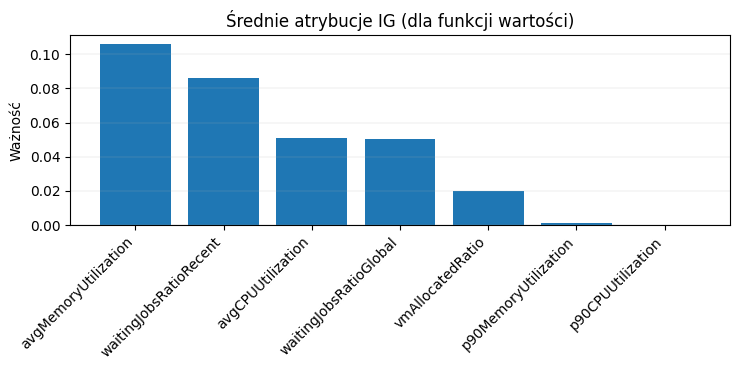

IG mean |attr|: [[0.02   0.0512 0.1058 0.0012 0.     0.0505 0.0859]]
IG mean signed: [[-0.0016  0.0391  0.1058 -0.0004  0.      0.0382 -0.0808]]


In [13]:
mean_abs, mean_signed, attrs = compute_ig_attributions(
    model, X, mode="value", n_steps=64, baseline="mean"
)

fig = plot_ig_bar(mean_abs, feature_names=FEATURE_NAMES,
                  title="Średnie atrybucje IG (dla funkcji wartości)")
display(fig)

print("IG mean |attr|:", np.round(mean_abs, 4))
print("IG mean signed:", np.round(mean_signed, 4))

c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\ipykernel_launcher.py:207: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later


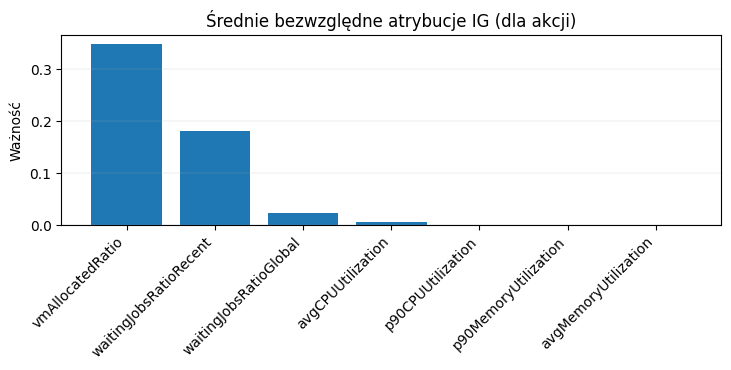

In [40]:
# choose a specific action index (or leave None to use argmax per state)
mean_abs_a, mean_signed_a, attrs_a = compute_ig_attributions(
    model, X, mode="action", action_index=None, n_steps=64, baseline="mean"
)

fig2 = plot_ig_bar(mean_abs_a, feature_names=FEATURE_NAMES,
                   title="Średnie bezwzględne atrybucje IG (dla akcji)")
display(fig2)

c:\Users\ultramarine\.conda\envs\trainloop_py37\lib\site-packages\ipykernel_launcher.py:111: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later


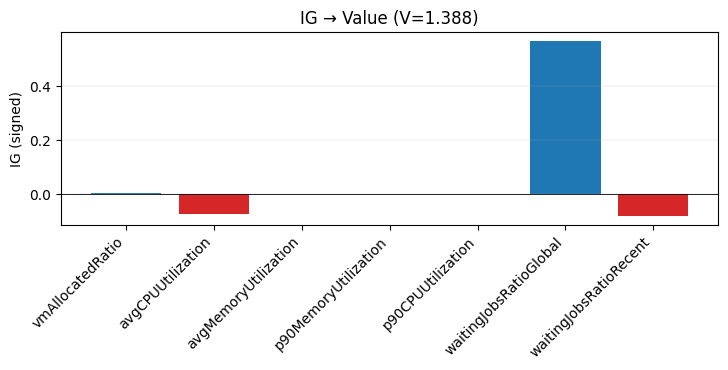

In [ ]:
# 1) Train normally with your AttentiveAWRLFeatureExtractor (or load an existing model)...
# model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs).learn(200_000)

# 2) Save
#save_model(model, "models/awrl_ppo.zip")

# 3) Load
#env = make_your_env_somehow()
#model_loaded = load_model("models/awrl_ppo.zip", env, algo="ppo")  # or "rppo"

# 4) Single-step prediction + attention
# obs, _ = env.reset()
# out = predict_with_attention(model, obs, deterministic=True)
# print("Action:", out["action"])
# print("Per-feature attention (len=7):", out["per_feature"])
# print("Attention matrix shape:", out["attention_matrix"].shape)

# # 5) Short sequence (works for RecurrentPPO too)
# obs_seq = []
# obs, _ = env.reset()
# for _ in range(8):
#     obs_seq.append(obs.copy())
#     action, _ = model_loaded.predict(obs, deterministic=True)
#     obs, *_ = env.step(action)
# obs_seq = np.stack(obs_seq, axis=0)

# seq_out = predict_sequence_with_attention(model_loaded, obs_seq)
# print("Seq actions:", seq_out["actions"])
# print("First step per-feature:", seq_out["per_feature_list"][0])
